In [22]:
import json
import pandas as pd
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize
from transformers import AutoTokenizer, AutoModel
import torch
from torchvision import transforms
from tqdm import tqdm
import numpy as np
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA

In [24]:
def cluster_active_map(input_pickle, hashtag_clusters_path, time_start, time_last):
    with open(hashtag_clusters_path, 'r') as f:
        hashtag_clusters = json.load(f)
    element_to_cluster = {element: cluster_id for cluster_id, elements in hashtag_clusters.items() for element in elements}

    df = pd.read_pickle(input_pickle)
    cluster_active_map = np.zeros((50, 10))
    time_gap = time_last - time_start + 1

    for index, row in tqdm(df.iterrows()):
        rawTweet = row['rawTweet']
        hashtags = set(x for x in rawTweet.split() if x.startswith('#'))
        time = row['time_published']
        time_diff = time - time_start

        time_range =  int(time_diff *10/time_gap)

        for hashtag in hashtags:
            cluster_id = element_to_cluster.get(hashtag, None)
            if cluster_id:
                c_id = int(cluster_id)
                cluster_active_map[c_id][time_range] += 1
    
    np.save("cluster_active_map.npy", cluster_active_map)
    pass

In [23]:
def dataset_spliter(input_pickle):
    df = pd.read_pickle(input_pickle)
    df_sorted = df.sort_values(by='time_published')
    train_set, test_set = train_test_split(df_sorted, test_size=0.1, shuffle=False)
    train_set.to_pickle("/home/dayouwu2/event_detection_Wally/hashtag_evaluation/Hamas_Isreal_Testing/hashtag_eval_train.pkl")

    time_first = train_set.iloc[0]['time_published']

    # validate_set, test_set = train_test_split(test_df, test_size=0.5, random_state=42)
    # validate_set.to_pickle("/home/dayouwu2/event_detection_Wally/hashtag_evaluation/Hamas_Isreal_Testing/hashtag_eval_validate.pkl")

    # time_second = validate_set.iloc[0]['time_published']

    test_set.to_pickle("/home/dayouwu2/event_detection_Wally/hashtag_evaluation/Hamas_Isreal_Testing/hashtag_eval_test.pkl")
    
    time_second = test_set.iloc[0]['time_published']
    time_last = test_set.iloc[-1]['time_published']

    return time_first, time_second, time_last

In [24]:
time_first, time_second, time_last = dataset_spliter("/home/dayouwu2/event_detection/event_detection_twitter/artifact_dir/temp_output/input_file.pkl")
print(time_first, time_second, time_last)

1693526714 1698667679 1698883198


In [25]:
cluster_active_map("/home/dayouwu2/event_detection/event_detection_twitter/artifact_dir/temp_output/input_file.pkl", "/home/dayouwu2/event_detection_Wally/hashtag_evaluation/hashtag_clusters.json", time_first, time_last)

3584175it [02:39, 22477.27it/s]


In [26]:
cluster_active_map = np.load("/home/dayouwu2/event_detection_Wally/hashtag_evaluation/cluster_active_map.npy")

In [28]:
print(cluster_active_map[])

[[0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
  2.21300e+03 1.24600e+03 3.77000e+02 6.27000e+02]
 [4.57000e+02 3.46000e+02 7.02000e+02 8.12000e+02 5.16000e+02 1.07965e+05
  2.51082e+05 1.00825e+05 6.81960e+04 1.17641e+05]
 [5.00000e+00 0.00000e+00 2.00000e+00 4.00000e+00 0.00000e+00 5.41100e+03
  4.19300e+03 3.53600e+03 5.37900e+03 4.56500e+03]
 [2.30000e+01 3.00000e+01 4.90000e+01 2.90000e+01 9.00000e+00 4.40000e+01
  1.72400e+03 1.75700e+03 3.66500e+03 1.60540e+04]
 [0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 2.76000e+02
  2.57700e+03 6.20000e+01 1.20000e+01 2.00000e+01]
 [0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 8.00000e+00
  5.18600e+03 2.91120e+04 4.38600e+03 6.19500e+03]
 [0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 1.95100e+03
  1.07000e+03 2.30000e+01 1.50000e+01 1.30000e+01]
 [0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 3.25400e+04
  7.19570e+04 1.28360e+04 3.93900e+03 4.60500e+03]


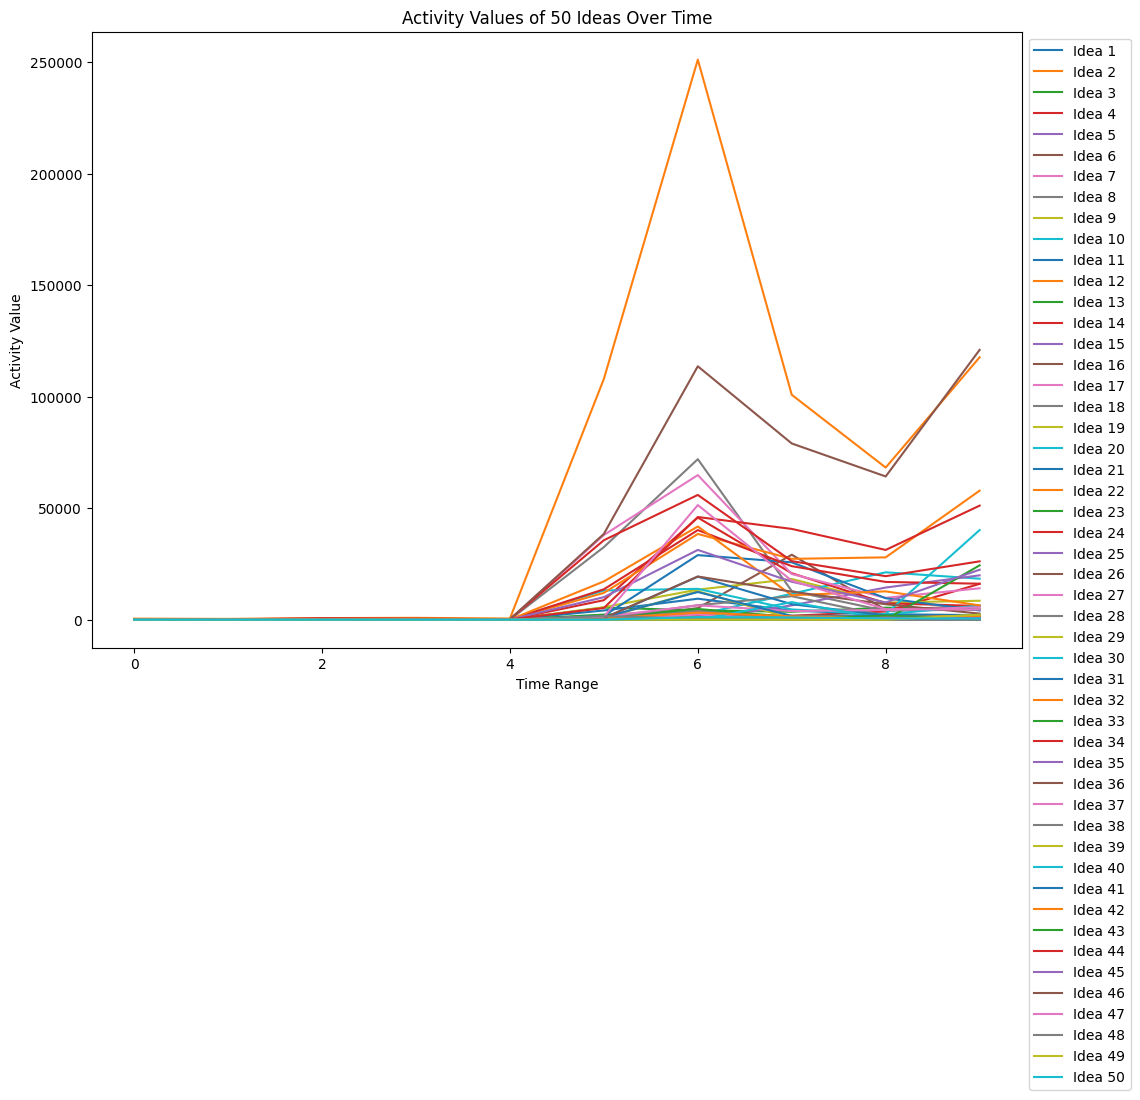

In [27]:
plt.figure(figsize=(12, 8))

# Assuming each column is a time range and each row is a different idea
time_ranges = np.arange(cluster_active_map.shape[1])  # 10 time ranges

for idea in cluster_active_map:
    plt.plot(time_ranges, idea)

plt.title('Activity Values of 50 Ideas Over Time')
plt.xlabel('Time Range')
plt.ylabel('Activity Value')
plt.legend(['Idea ' + str(i) for i in range(1, 51)], loc='upper left', bbox_to_anchor=(1, 1))  # Optional: Add a legend

plt.show()

In [25]:
def cluster_time_map_to_train(cluster, time_first, time_last):
    time_gap = time_last - time_first + 1
    result = np.zeros(9)
    for timestamp in cluster:
        time_diff = timestamp - time_first
        timeId = time_diff * 9 / time_gap
        result[int(timeId)] += 1
    return result

def logReg_dataset_prep(user_cluster_time_map_path, time_first, time_last):
    with open(user_cluster_time_map_path, 'r') as f:
        user_cluster_time_map = json.load(f)
    
    x_train = np.zeros((len(user_cluster_time_map) * 50, 8))
    y_train = np.zeros(len(user_cluster_time_map) * 50)
    index = -1
    for user in tqdm(user_cluster_time_map):
        index += 1
        for cluster_id in user_cluster_time_map[user]:
            cluster = user_cluster_time_map[user][cluster_id]
            array = cluster_time_map_to_train(cluster, time_first, time_last)
            row_id = int(cluster_id) + 50*index
            x_train[row_id] = array[:8]
            if array[8] > 0:
                y_train[row_id] = 1
    
    np.save("x_train.npy", x_train)
    np.save("y_train.npy", y_train)
    pass


In [26]:
logReg_dataset_prep("/home/dayouwu2/event_detection_Wally/hashtag_evaluation/Hamas_Isreal_Testing/user_time_cluster_map.json", time_first, time_second)

100%|██████████| 399271/399271 [00:03<00:00, 101620.59it/s]


In [ ]:
def logReg_classifier()